In [1]:
#LORA CONFIG

rank = 16
alpha = 64

In [1]:
import torch
import os

def fix_checkpoint_compatibility(checkpoint_path):
    """Fix checkpoint to be compatible with current PyTorch Lightning version"""
    if checkpoint_path is None or not os.path.exists(checkpoint_path):
        return checkpoint_path
    
    try:
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        
        # Add missing pytorch-lightning version if not present
        if 'pytorch-lightning_version' not in checkpoint:
            checkpoint['pytorch-lightning_version'] = '1.9.0'
            
        # Fix other potential compatibility issues
        if 'state_dict' in checkpoint:
            # Checkpoint is valid
            torch.save(checkpoint, checkpoint_path + '.fixed')
            print(f"Fixed checkpoint saved to {checkpoint_path}.fixed")
            return checkpoint_path + '.fixed'
    except Exception as e:
        print(f"Could not fix checkpoint: {e}")
        return None
    
    return checkpoint_path

torch.cuda.empty_cache()


In [51]:
# %%
import torch
import numpy as np
from PIL import Image
from omegaconf import OmegaConf
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from lora import loraModel
import matplotlib.pyplot as plt

# %%
# 1. Configuration
config_path = "models/ldm/inpainting_big/config.yaml"
ckpt_path = "models/ldm/inpainting_big/last.ckpt"
lora_weights_path = "lora_checkpoints/lora_epoch_350.pt" # Your trained weights
device = "cuda"

# %%
# 2. Load Model
def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")

    # --- THE FIX: Remove the reference to the missing VAE file ---
    if "first_stage_config" in config.model.params:
        if "ckpt_path" in config.model.params.first_stage_config.params:
            print("Patched config: Removing reference to missing first_stage_model.")
            del config.model.params.first_stage_config.params["ckpt_path"]
    # -------------------------------------------------------------

    pl_sd = torch.load(ckpt, map_location="cpu")
    if "state_dict" in pl_sd:
        sd = pl_sd["state_dict"]
    else:
        sd = pl_sd

    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)

    if len(m) > 0 and verbose:
        print("missing keys:", m)
    if len(u) > 0 and verbose:
        print("unexpected keys:", u)

    model.cuda()
    model.eval()
    return model

config = OmegaConf.load(config_path)
model = load_model_from_config(config, ckpt_path)
"""
# %%
# 3. Apply your LoRA
old_unet = model.model.diffusion_model

# !!! INSERT YOUR LORA INJECTION LOGIC HERE !!!

unet = loraModel(old_unet, rank=rank, alpha=alpha, qkv=[True, True, True])
unet.set_trainable_parameters()

# Load your trained LoRA state dict
print("Loading LoRA weights...")
lora_sd = torch.load(lora_weights_path)
missing, unexpected = unet.model.load_state_dict(lora_sd, strict=False)
print(f"LoRA load missing: {len(missing)}, unexpected: {len(unexpected)}")

# quick sanity on LoRA weights
vals = [p.abs().mean().item() for n,p in unet.model.named_parameters() if 'lora_B' in n]
print('LoRA B mean abs (avg):', sum(vals)/len(vals) if vals else None)

model.model.diffusion_model = unet
model.cuda()

"""
# 4. Sampler Setup
sampler = DDIMSampler(model)



Loading model from models/ldm/inpainting_big/last.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 387.25 M params.
Keeping EMAs of 418.
making attention of type 'none' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'none' with 512 in_channels
Using first stage also as cond stage.


In [52]:
def make_rect_mask_img_batch(image, rectlims, device):
    image = np.array(Image.open(image).convert("RGB"))
    image = image.astype(np.float32)/255.0
    image = image[None].transpose(0,3,1,2)
    image = torch.from_numpy(image)
    print(image.shape)

    mask = np.ones(image.shape[:])
    mask = mask.astype(np.float32)/255.0
    mask[:,:,rectlims[0][0]:rectlims[0][1], rectlims[1][0]:rectlims[1][1]] = 1
    mask = torch.from_numpy(mask)
    print(mask.shape)

    masked_image = (1-mask)*image
    print(masked_image.shape)

    batch = {"image": image, "mask": mask, "masked_image": masked_image}
    for k in batch:
        batch[k] = batch[k].to(device=device)
        batch[k] = batch[k]*2.0-1.0
    return batch

In [59]:
image = 'test_images/celeba25.jpg'
llims = [[80,130],[80,130]]
steps = 70

with torch.no_grad():
        with model.ema_scope():
            batch = make_rect_mask_img_batch(image, llims, device=device)

            # encode masked image and concat downsampled mask
            c = model.cond_stage_model.encode(batch["masked_image"])
            print(c.shape,batch["mask"][0,0].shape)
            cc = torch.nn.functional.interpolate(batch["mask"],
                                                 size=c.shape[-2:])[:,:1]
            print(cc.shape)
            c = torch.cat((c, cc), dim=1)

            shape = (c.shape[1]-1,)+c.shape[2:]
            samples_ddim, _ = sampler.sample(S=steps,
                                             conditioning=c,
                                             batch_size=c.shape[0],
                                             shape=shape,
                                             verbose=False)
            x_samples_ddim = model.decode_first_stage(samples_ddim)

            image = torch.clamp((batch["image"]+1.0)/2.0,
                                min=0.0, max=1.0)
            mask = torch.clamp((batch["mask"]+1.0)/2.0,
                               min=0.0, max=1.0)
            predicted_image = torch.clamp((x_samples_ddim+1.0)/2.0,
                                          min=0.0, max=1.0)

            inpainted = (1-mask)*image+mask*predicted_image
            inpainted = inpainted.cpu().numpy().transpose(0,2,3,1)[0]

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 64, 64]) torch.Size([256, 256])
torch.Size([1, 1, 64, 64])
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 72 timesteps


DDIM Sampler: 100%|██████████| 72/72 [00:06<00:00, 11.32it/s]


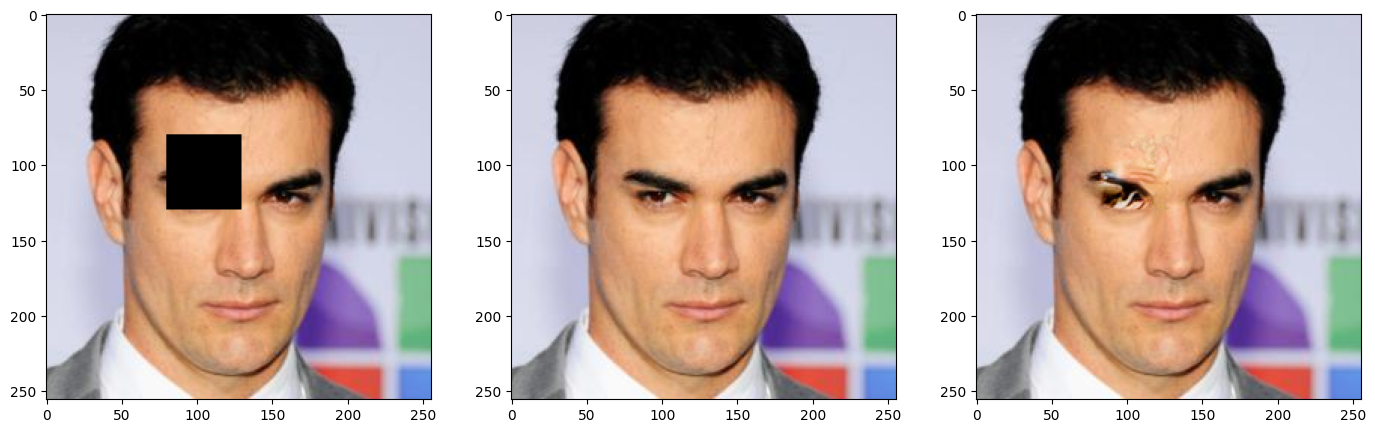

In [60]:
fig, ax = plt.subplots(1,3,figsize=[17,5])
ax[0].imshow(((batch['masked_image'].detach()+1)/2).cpu().numpy().transpose(0,2,3,1)[0])
ax[1].imshow(((batch['image'].detach()+1)/2).cpu().numpy().transpose(0,2,3,1)[0])
ax[2].imshow(inpainted)

In [ ]:
# %%
# 5. Generate
# Define parameters
classes = None # Unconditional
n_samples = 1
ddim_steps = 50
ddim_eta = 0.0 # 0 for deterministic, 1 for stochastic
scale = 1.0 # Unconditional guidance scale (doesn't matter much if unconditional)

# Resolution of latents (256px image -> 64x64 latent for f=4 model)
h, w = 256, 256
c = 3
f = 4 # Downsampling factor
shape = [c, h // f, w // f]

with torch.no_grad():
    # Sample from noise
    samples, _ = sampler.sample(
        S=ddim_steps,
        batch_size=n_samples,
        shape=shape,
        eta=ddim_eta,
        verbose=False
    )

    # Decode latents to images
    x_samples_ddim = model.decode_first_stage(samples)

    # Normalize back to [0, 255]
    x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)
    x_samples_ddim = x_samples_ddim.cpu().permute(0, 2, 3, 1).numpy()

    # Convert to image
    x_image_torch = torch.from_numpy(x_samples_ddim).float()
    x_sample = 255. * x_image_torch
    img = x_sample[0].numpy().astype(np.uint8)

    display_img = Image.fromarray(img)
    display_img.save("result_legacy.png")
    display_img.show()

--- Generating Comparison (Seed: 123) ---
1. Sampling with LoRA ENABLED...
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 14.37it/s]


2. Sampling with LoRA DISABLED (Base Model)...
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 14.20it/s]


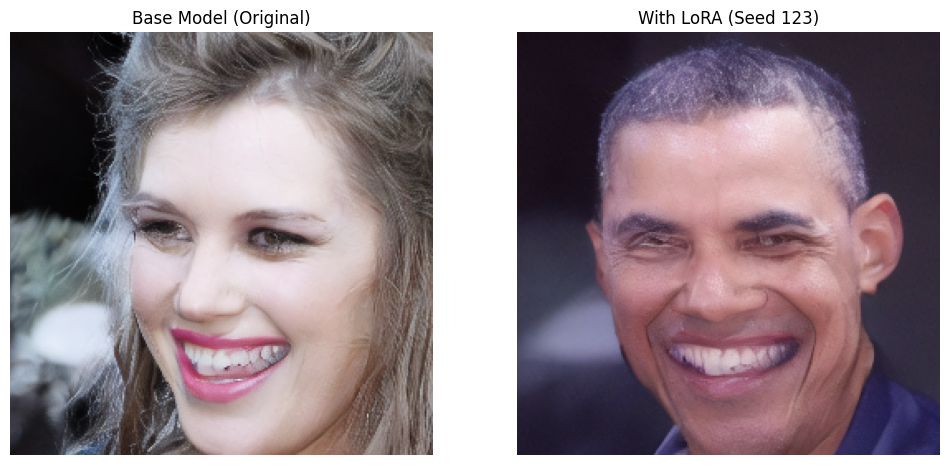

In [12]:
import torch
import numpy as np
from PIL import Image
from einops import rearrange
import matplotlib.pyplot as plt

def generate_comparison(model, sampler, seed=42, steps=50):
    print(f"--- Generating Comparison (Seed: {seed}) ---")

    # 1. Setup Deterministic Noise
    # We create the noise ONCE and pass it to both runs.
    # This ensures the 'randomness' is identical for both.
    generator = torch.Generator(device="cuda").manual_seed(seed)

    # Dimensions for CelebA-HQ 256 (Latent 64x64, 3 channels)
    h, w = 256, 256
    f = 4
    c = 3
    shape = [c, h // f, w // f]

    # Generate the noise tensor on GPU
    # Note: DDIMSampler expects (Batch, Channel, Height, Width)
    x_T = torch.randn((1, *shape), generator=generator, device="cuda")

    # ---------------------------------------------------------
    # RUN 1: LoRA ON
    # ---------------------------------------------------------
    print("1. Sampling with LoRA ENABLED...")

    # LoRA strength relative to original scaling (alpha/rank)
    unet = model.model.diffusion_model

    def set_lora_strength(target_model, strength):
        count = 0
        for module in target_model.modules():
            if hasattr(module, 'scaling'):
                if not hasattr(module, '_original_scaling'):
                    module._original_scaling = module.scaling
                module.scaling = module._original_scaling * strength
                count += 1
        return count

    set_lora_strength(unet, 1.0) # Full LoRA (uses original scaling)

    with torch.no_grad():
        samples_lora, _ = sampler.sample(
            S=steps,
            batch_size=1,
            shape=shape,
            x_T=x_T, # <--- CRITICAL: Pass the fixed noise here
            eta=0.0,
            verbose=False
        )

    # ---------------------------------------------------------
    # RUN 2: LoRA OFF (Base Model)
    # ---------------------------------------------------------
    print("2. Sampling with LoRA DISABLED (Base Model)...")

    # Temporarily set scaling to 0.0 to mute the LoRA layers
    found_layers = set_lora_strength(unet, 0.0)
    if found_layers == 0:
        print("WARNING: Could not find LoRA layers to disable! Comparison might be invalid.")

    with torch.no_grad():
        samples_base, _ = sampler.sample(
            S=steps,
            batch_size=1,
            shape=shape,
            x_T=x_T, # <--- CRITICAL: Reuse the EXACT SAME noise
            eta=0.0,
            verbose=False
        )

    # Restore scaling to 1.0 for future runs
    set_lora_strength(unet, 1.0)

    # ---------------------------------------------------------
    # Decode and Display
    # ---------------------------------------------------------
    def decode_img(samples):
        x_decoded = model.decode_first_stage(samples)
        x_decoded = torch.clamp((x_decoded + 1.0) / 2.0, min=0.0, max=1.0)
        x_decoded = x_decoded.cpu().permute(0, 2, 3, 1).numpy()
        return (255. * x_decoded[0]).astype(np.uint8)

    img_lora = decode_img(samples_lora)
    img_base = decode_img(samples_base)

    # Plot Side by Side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(img_base)
    ax[0].set_title("Base Model (Original)")
    ax[0].axis('off')

    ax[1].imshow(img_lora)
    ax[1].set_title(f"With LoRA (Seed {seed})")
    ax[1].axis('off')

    plt.show()

# Run the comparison
generate_comparison(model, sampler, seed=123)

Loading model from celeba/model.ckpt
Patched config: Removing reference to missing first_stage_model.
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Training LatentDiffusion as an unconditional model.
trainable params: 1449856 || all params: 275506019 || trainable%: 0.5263
Loading LoRA weights...
LoRA load missing: 368, unexpected: 0
LoRA B Matrices: 128 total
Zero-Initialized: 0 (Should be 0 if loaded correctly!)
Updated LoRA strength to 0.0 for 16 layers.
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 13.85it/s]


Updated LoRA strength to 0.25 for 16 layers.
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 14.05it/s]


Updated LoRA strength to 0.5 for 16 layers.
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 14.08it/s]


Updated LoRA strength to 0.75 for 16 layers.
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 12.92it/s]


Updated LoRA strength to 1.0 for 16 layers.
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 13.98it/s]


Updated LoRA strength to 1.25 for 16 layers.
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 14.18it/s]


Updated LoRA strength to 1.5 for 16 layers.
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 13.62it/s]


Updated LoRA strength to 1.75 for 16 layers.
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 14.29it/s]


Updated LoRA strength to 2.0 for 16 layers.
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 14.39it/s]


Updated LoRA strength to 2.25 for 16 layers.
Data shape for DDIM sampling is (1, 3, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:03<00:00, 14.54it/s]


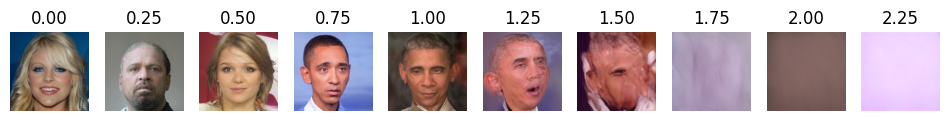

In [13]:
# Run this AFTER you have loaded the model and attached the LoRA

def set_lora_strength(model, strength):
    """
    Manually updates the scaling factor of all LoRA layers.
    strength = 1.0 -> Full LoRA
    strength = 0.5 -> Half strength
    strength = 0.0 -> Original Model
    """
    unet = model.model.diffusion_model
    count = 0

    for module in unet.modules():
        if hasattr(module, "scaling"):
            # Store original scaling if not already stored
            if not hasattr(module, "_original_scaling"):
                module._original_scaling = module.scaling

            # Scale the original value
            module.scaling = module._original_scaling * strength
            count += 1

    print(f"Updated LoRA strength to {strength} for {count} layers.")

# --- TRY THIS ---
# 1. Configuration
config_path = "configs/latent-diffusion/celebahq-ldm-vq-4.yaml"
ckpt_path = "celeba/model.ckpt"
lora_weights_path = "lora_checkpoints/lora_epoch_300.pt" # Your trained weights
device = "cuda"

# %%
# 2. Load Model
def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")

    # --- THE FIX: Remove the reference to the missing VAE file ---
    if "first_stage_config" in config.model.params:
        if "ckpt_path" in config.model.params.first_stage_config.params:
            print("Patched config: Removing reference to missing first_stage_model.")
            del config.model.params.first_stage_config.params["ckpt_path"]
    # -------------------------------------------------------------

    pl_sd = torch.load(ckpt, map_location="cpu")
    if "state_dict" in pl_sd:
        sd = pl_sd["state_dict"]
    else:
        sd = pl_sd

    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)

    if len(m) > 0 and verbose:
        print("missing keys:", m)
    if len(u) > 0 and verbose:
        print("unexpected keys:", u)

    model.cuda()
    model.eval()
    return model

config = OmegaConf.load(config_path)
model = load_model_from_config(config, ckpt_path)

# %%
# 3. Apply your LoRA
unet = model.model.diffusion_model

# !!! INSERT YOUR LORA INJECTION LOGIC HERE !!!

unet = loraModel(unet, rank=rank, alpha=alpha, qkv=[True, True, True])
unet.set_trainable_parameters()
model.model.diffusion_model = unet

# Load your trained LoRA state dict
# You might need to filter keys if you saved the whole UNet
print("Loading LoRA weights...")
lora_sd = torch.load(lora_weights_path)
missing, unexpected = unet.model.load_state_dict(lora_sd, strict=False)
print(f"LoRA load missing: {len(missing)}, unexpected: {len(unexpected)}")


# Check if LoRA weights are actually non-zero
def check_lora_weights(model):
    zeros = 0
    total = 0
    for name, param in model.named_parameters():
        if "lora_B" in name:
            total += 1
            if torch.all(param == 0):
                zeros += 1

    print(f"LoRA B Matrices: {total} total")
    print(f"Zero-Initialized: {zeros} (Should be 0 if loaded correctly!)")

    if zeros == total and total > 0:
        print("❌ CRITICAL: Your LoRA weights are all zero. The load_state_dict failed.")
        print("   Solution: Print the keys in lora_sd and model.state_dict() to compare them.")

check_lora_weights(unet)


model.model.diffusion_model = unet
model.cuda()
# 4. Sampler Setup
sampler = DDIMSampler(model)
# 1. Reduce strength to 0.5 or 0.2 to see if distortion disappears
def decode_img(samples):
        x_decoded = model.decode_first_stage(samples)
        x_decoded = torch.clamp((x_decoded + 1.0) / 2.0, min=0.0, max=1.0)
        x_decoded = x_decoded.cpu().permute(0, 2, 3, 1).numpy()
        return (255. * x_decoded[0]).astype(np.uint8)

N = 10
img_lora = []
# 2. Run your sampler code again
with torch.no_grad():

  for i in range(N):
    set_lora_strength(model, strength=i/4)
    samples, _ = sampler.sample(S=50, batch_size=1, shape=shape, eta=0.0, verbose=False)
    # ... decode and show image ...

    img_lora.append( decode_img(samples) )

    # Plot Side by Side

fig, ax = plt.subplots(1, N, figsize=(12, 6))

for i in range(N):
  ax[i].imshow(img_lora[i])
  ax[i].set_title(f"{(i/4):.2f}")
  ax[i].axis('off')

plt.show()
